Reproducing the Hodgkin-Huxley experiment. Note that this experiment takes a long time due to simulation of the SGD of the model.

In [22]:
import os
os.environ["MKL_NUM_THREADS"]="12" 
os.environ["NUMEXPR_NUM_THREADS"]='12'
os.environ["OMP_NUM_THREADS"]='12'
import matplotlib.pyplot as plt
import types
import numpy as np
import tqdm.notebook
import torch
from torch import optim

%matplotlib inline

from importlib import reload


import Generators, Features, Data, Likelihoods

import KernelWakeSleep as kws

import Models

device = torch.device("cpu")
dtype  = torch.double
reload(Data)
reload(Models)

<module 'Models' from '/nfs/ghome/live/kevinli/Code/kws/Models.py'>

In [23]:
batch_size = 200
nsleep = 2000
nepoch = 10
nvalid = 200
torch.manual_seed(0)
np.random.seed(0)

# data

In [24]:
def sleep(gmm, *args):
    return gmm.sample_logp(*args)

In [25]:
T = 1000
I = torch.cat([torch.randn(100)*2, torch.randn(800)*2+10, torch.randn(100)*2])
true_HH = Models.HodgkinHuxley(z0 = [-70, 0, 0.8, 0.0],
                        C_m=1.0,   #muF/cm2
                        g_l=0.1,   #mS/cm2
                        E_l=-70.42,  #mV
                        g_na=50.0, 
                        E_na=50.0, 
                        g_k=5.0, 
                        E_k=-90.0, 
                        V_t=-60.0, 
                        rand_std=0.1,
                        noise_std=1.0,
                       dt = 0.05).type(dtype)

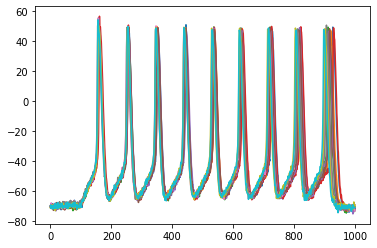

In [26]:
true_z, true_x =  true_HH.sample(10,I)
plt.plot(true_x.detach().cpu().numpy().T);

In [27]:
HH = Models.HodgkinHuxley(z0 = [-70, 0, 0.8, 0.0],
                        C_m=2.0,   #muF/cm2
                        g_l=0.2,   #mS/cm2
                        E_l=-60,  #mV
                        g_na=40.0, 
                        E_na=40.0, 
                        g_k=3.0, 
                        E_k=-80.0, 
                        V_t=-50.0, 
                        rand_std=1.,
                        noise_std=30.0,
                       dt = 0.05).to(device).type(dtype)

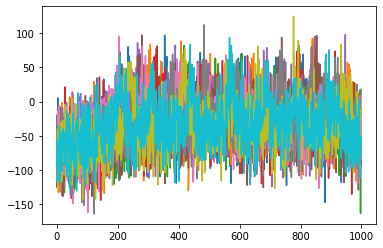

In [28]:
_, x =  HH.sample(10, I)
plt.plot(x.detach().cpu().numpy().T);

In [38]:
_, s = HH.sample(10, I)
kernel_networks = [Features.lin_feat(T,100, bn=False).type(dtype)]
s = kernel_networks[0](s)
sigma = kws.estimate_median_distance(s)
kernel = kws.RFKernel(100, kernel_networks, sigma=sigma, lam=1e-3, train_sigma=True, train_lam=True)
kernel.to(device).type(dtype)

RFKernel()

In [39]:
optimizer = optim.Adam(list(HH.parameters()), lr=0.001)
kernel_optimizer = optim.Adam(kernel.parameters(), lr=0.001)


Elogps = []
losses = []

log_lams = []
log_sigmas = []

network_norms = []
kernel_network_norms = []
kernel_network_feat_norms = []
noise_stds = []
rand_stds = []

network_grad_norms = []

In [40]:
record_dict = dict()

param_names = ["C_m", "g_l", "E_l", "g_na", "E_na", "g_k", "E_k", "V_t", "rand_std", "noise_std"]

for pn in param_names:
    record_dict[pn] = []

In [41]:
import gc
gc.collect()

HH.train()
kernel.train()
nsleep = 2000
with tqdm.notebook.tqdm(range(50000)) as t:
    for ei in t:


        X_tr = true_x[:1].to(device)

        data_0, data_1, norm, nat = sleep(HH, nsleep, I)
        data_0_val, data_1_val, norm_val, nat_val = sleep(HH, nvalid, I)
        S_val = HH.suff(data_1_val)
        
        if ei % 1 == 0:

            kernel_optimizer.zero_grad()

            Elogp_val = kws.KRR_2(HH.suff, kernel, data_1_val, data_1, norm.detach(), nat.detach()).mean()
            logp_true= (nat_val * S_val).sum(-1) - norm_val 
            loss_val = torch.mean((Elogp_val - logp_true )**2)

            loss_val.backward(retain_graph=False)

            kernel_optimizer.step()

            network_grad_norm = sum(map(lambda x: (x.grad**2).sum() if x.grad is not None else 0, kernel.parameters()))

            losses += loss_val.detach().cpu().numpy(),

            log_lams += kernel.log_lam.cpu().detach().numpy().copy(),
            log_sigmas += kernel.log_sigma.cpu().detach().numpy().copy(),

        Elogp = kws.KRR_2(HH.suff, kernel, X_tr, data_1, norm, nat).mean()
        network_norm = sum(map(lambda x: (x**2).sum(), HH.parameters()))

        gen_loss = -Elogp 

        Elogps += Elogp.mean().detach().cpu().numpy(),

        optimizer.zero_grad()
        gen_loss.backward(retain_graph=False)

        network_norms += network_norm,
        network_grad_norm = sum(map(lambda x: (x.grad**2).sum() if x.grad is not None else 0, HH.parameters()))
        network_grad_norms += network_grad_norm,


        optimizer.step()
        t.set_postfix(Elogp=Elogp.item())


        for pn in param_names:
            param_value = getattr(HH, pn).exp()
            if pn in ["E_l", "E_k", "V_t"]:
                param_value = -param_value
            record_dict[pn].append(param_value)
        
        noise_stds += HH.noise_std.exp().detach().cpu().numpy(),
        rand_stds += HH.rand_std.exp().detach().cpu().numpy(),

KeyboardInterrupt: 

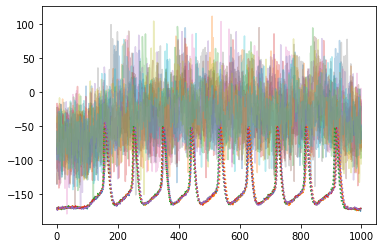

In [42]:
_, x = HH.sample(10,I)
_, true_x = true_HH.sample(10,I)
plt.plot(x.cpu().numpy().T, alpha=0.3)
plt.plot(true_x[0:5].cpu().numpy().T-100, ':');

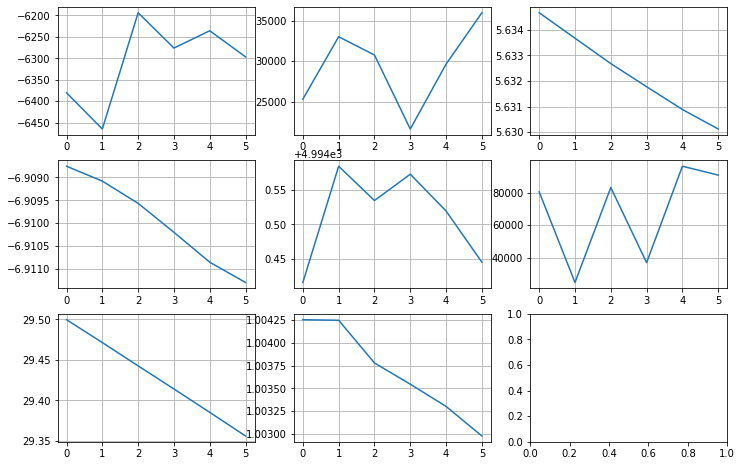

In [43]:
params = [Elogps,losses, log_sigmas, 
          log_lams, network_norms, network_grad_norms, 
          noise_stds, rand_stds]

nplot = len(params)
fig, axes = plt.subplots(3,3, figsize=(12,8), sharex=False)
axes = np.ravel(axes)
for i in range(nplot):
    axes[i].plot(params[i])
    axes[i].grid(True)
# axes[0].set_xlim([20000,2000])

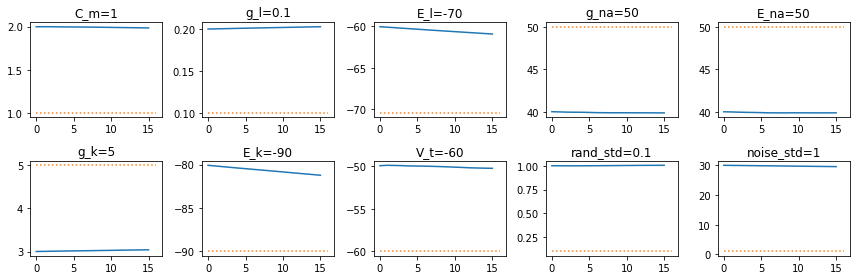

In [37]:
fig, axes = plt.subplots(2,5, figsize=(12,4))
axes = np.reshape(axes,-1)
for pi, pn in enumerate(param_names):
    ax = axes[pi]
    ax.plot(record_dict[pn])
    length = len(record_dict[pn])
    true_value  = getattr(true_HH,pn).exp()
    if pn in ["E_l", "E_k", "V_t"]:
        true_value = -true_value
    ax.plot([0, length], [true_value, true_value], ":")

    ax.set_title(pn+"=%.2g"%true_value)
plt.tight_layout()